In [1]:
import pandas as pd
import numpy as np
import glob
import laspy
import cv2

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import rasterio
from rasterio.features import shapes

import shapely
from shapely.geometry import Polygon, mapping
from PIL import Image
from matplotlib.path import Path as plt_path

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class ConvUNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #""" Encoder """
        self.e1 = encoder_block(1, 64).cuda()
        self.e2 = encoder_block(64, 128).cuda()
        self.e3 = encoder_block(128, 256).cuda()
        self.e4 = encoder_block(256, 512).cuda()
        #""" Bottleneck """
        self.b = conv_block(512, 1024).cuda()
        #""" Decoder """
        self.d1 = decoder_block(1024, 512).cuda()
        self.d2 = decoder_block(512, 256).cuda()
        self.d3 = decoder_block(256, 128).cuda()
        self.d4 = decoder_block(128, 64).cuda()
        #""" Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0).cuda()
    
    def forward(self, inputs):
        #""" Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        #""" Bottleneck """
        b = self.b(p4)

        #""" Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        #""" Classifier """
        outputs = self.outputs(d4)
        return outputs


class PolygonCNN(object):
    
    def __init__(self, path_to_data, path_to_model, network_size, image_size, meters_around_line, cc_area,simplify_tolerance):
        self.path_to_data = path_to_data
        self.model = ConvUNet()
        self.model.load_state_dict(torch.load(path_to_model))
        self.network_size = network_size
        self.image_size = image_size
        self.meters_around_line = meters_around_line
        self.cc_area = cc_area
        self.simplify_tolerance = simplify_tolerance
        self.transform_img_gray = transforms.Compose([transforms.Resize((image_size,image_size)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    def __call__(self, filename):
        lines_image = self.ImageProcessing(filename)
        reg_polygons, multi_polygons, bbox_reg_polygon, bbox_multi_polygons = self.Polygonize(lines_image)
        point_cloud = laspy.read(self.path_to_data+'/LazFilesWithHeightParam/'+filename+'_hag_nn.laz', laz_backend=laspy.compression.LazBackend.LazrsParallel)
        indexes_needed = self.FilterPolygons(reg_polygons, multi_polygons, bbox_reg_polygon, bbox_multi_polygons, point_cloud, lines_image)
        new_las = self.Predictions(indexes_needed, point_cloud)
        return new_las

    
    def BBTouchingEdge(self, image_shape, bb, epsilon):
        image_width, image_height = image_shape
        left, top, width, height = bb[0], bb[1], bb[2], bb[3]
        right = left + width
        bottom = top + height
        distance_to_left = left
        distance_to_right = image_width - right
        distance_to_top = top
        distance_to_bottom = image_height - bottom

        if distance_to_left > epsilon and distance_to_right > epsilon and distance_to_top > epsilon and distance_to_bottom > epsilon:
            return False
        else:
            return True    
    
    def ImageProcessing(self, filename):
        # Load Image
        image = cv2.imread(self.path_to_data+'/ImagesGroundRemovedLarge/'+filename+'_max.tif', cv2.IMREAD_UNCHANGED)
        image = np.where(image >= 0, image, 0)
        image = image/np.max(image)
        image = (image*255).astype(np.uint8)

        # Create pil image
        pil_image = Image.fromarray(image)

        # Resize Image, Transform to tensor, and Normalize
        tensor_image = self.transform_img_gray(pil_image)
        x_pixels, y_pixels = tensor_image[0].shape
        
        # Crop the image into equal parts
        network_size = self.network_size
        image_size = self.image_size
        amount_of_crops = image_size // network_size
        
        cropped_image_list = []
        for i in range(amount_of_crops):
            # Generate slice indices
            x_start_index = network_size*i
            x_end_index = network_size*(i+1)
            for j in range(amount_of_crops):
                y_start_index = network_size*j
                y_end_index = network_size*(j+1)
                # Slice image of size [1, image_size, image_size] and obtain the cropped image
                cropped_image = tensor_image[0][x_start_index:x_end_index,y_start_index:y_end_index]
                cropped_image_list.append(cropped_image.unsqueeze(0).unsqueeze(0))

        # Apply model
        output_list = []
        self.model.eval()
        with torch.no_grad():
            for small_img in cropped_image_list:
                outputs = torch.squeeze(self.model(small_img.cuda())).detach().cpu()
                outputs = torch.round(torch.sigmoid(outputs)) # Predict either 0 or 1.
                output_list.append(outputs)
            
        row_images = []
        for i in range(amount_of_crops):
            # to obtain each row in an image
            row_to_concat = output_list[(i)*amount_of_crops:(i+1)*amount_of_crops]
            stacked_array = np.concatenate([arr for arr in row_to_concat], axis=1)
            row_images.append(stacked_array)
        

        lines_image = np.concatenate([arr for arr in row_images], axis=0)
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(11,11))
        ax0.imshow(image, cmap='gray')
        ax0.set_title('Original Image', size=8)

        ax1.imshow(lines_image, cmap='gray')
        ax1.set_title('Segmented Image', size=8)

        # Get pixels per meter to create a cirkular kernel size of size "meters_around_line"
        x_pixels, y_pixels = x_pixels/1000, y_pixels/1000
        kernel_size = int(self.meters_around_line*np.ceil(x_pixels))
        circular_kernel = np.ones((kernel_size, kernel_size), np.uint8)
        
        # Create a cirkular kernel using (image, center_coordinates, radius, color, thickness)
        cv2.circle(circular_kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 255, -1)
        # Apply dilation using the cirkular kernel
        lines_image = cv2.dilate(lines_image, circular_kernel, iterations=1)
        ax2.imshow(lines_image, cmap='gray')
        ax2.set_title('~'+str(self.meters_around_line)+' Meters\nDilation', size=8)
        
        
        # Must be image type for connected components
        lines_image = (lines_image * 255).astype(np.uint8)
        (_, label_ids, bounding_box, _) = cv2.connectedComponentsWithStats(lines_image)
        for i in range(len(bounding_box)):
            # Must be 10 Pixels from the edge of the image
            if not self.BBTouchingEdge(image.shape, bounding_box[i], 10):
                area = bounding_box[i][cv2.CC_STAT_AREA]
                if area < cc_area:
                    lines_image[label_ids == i] = 0
        
        
        ax3.imshow(lines_image, cmap='gray')
        ax3.set_title('Prediction\nConnected Components', size=8)

#         ax0.axis('off')
#         ax1.axis('off')
#         ax2.axis('off')
#         ax3.axis('off')
        
        plt.savefig('images_test/'+filename+'.png', dpi = 200, bbox_inches = 'tight')
        return lines_image
    
    
    
        
    def Polygonize(self, lines_image):
        # Create Polygons and Multi Polygons
        mask = (lines_image == 255)
        output = rasterio.features.shapes(lines_image, mask=mask, connectivity=4)
        output_list = list(output)

        # Seperate the Multipolygons and Polygons
        all_polygons = []
        all_multi_polygons =[]
        #ipdb.set_trace()

        for multi_polygon in output_list:
            found_polygon = multi_polygon[0]['coordinates']
            # Then its just a Polygon
            if len(found_polygon) == 1:
                all_polygons.append(Polygon(found_polygon[0]))
            # Else its a multipolygon
            else:
                tmpMulti = []
                for p in found_polygon:
                    tmpMulti.append(Polygon(p))
                all_multi_polygons.append(tmpMulti)

        # Remove all low area multipolygons
        for i, multi_pol in enumerate(all_multi_polygons):
            new_list = [multi_pol[0]]
            # No matter what, dont remove the first one
            for pol in multi_pol[1:]:
                new_list.append(pol)
            all_multi_polygons[i] = new_list

        simplified_all_polygons = []
        simplified_all_multi_polygons =[]
        # Simplify all standard polygons
        for p in all_polygons:
            simplified_all_polygons.append(shapely.simplify(p, tolerance=self.simplify_tolerance, preserve_topology=True))
        simplified_all_polygons  = [p for p in simplified_all_polygons if not p.is_empty]

        # Simplify all multi polygons
        for multi_pol in all_multi_polygons:
            tmp = []
            for p in multi_pol:
                tmp.append(shapely.simplify(p, tolerance=self.simplify_tolerance, preserve_topology=True))
            tmp  = [p for p in tmp if not p.is_empty]
            simplified_all_multi_polygons.append(tmp)

        # Create bounding box polygons
        bbox_all_polygon_path = []
        tmp = [p.bounds for p in simplified_all_polygons]
        for values in tmp:
            #values = (minx, miny, maxx, maxy)#
            x_min = values[0]
            x_max = values[2]
            y_min = values[1]
            y_max = values[3]
            bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
            bbox_all_polygon_path.append(plt_path(bb))

        # Create bounding box for multi polygons
        bbox_all_multi_polygons_path = []
        for multi_pol in simplified_all_multi_polygons:
            tmp = [p.bounds for p in multi_pol]
            tmp_multi_pol_boxes = []

            for values in tmp:
                #values = (minx, miny, maxx, maxy)
                x_min = values[0]
                x_max = values[2]
                y_min = values[1]
                y_max = values[3]
                bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
                tmp_multi_pol_boxes.append(plt_path(bb))
            bbox_all_multi_polygons_path.append(tmp_multi_pol_boxes)

        # Create plt_path polygons from the simplified shapely polygons
        simplified_all_polygons_path = [plt_path(mapping(p)['coordinates'][0]) for p in simplified_all_polygons]
        simplified_all_multi_polygons_path = []
        for multi_pol in simplified_all_multi_polygons:
            tmp = [plt_path(mapping(p)['coordinates'][0]) for p in multi_pol]
            simplified_all_multi_polygons_path.append(tmp)

        return simplified_all_polygons_path, simplified_all_multi_polygons_path, bbox_all_polygon_path, bbox_all_multi_polygons_path
    
    def MaxMinNormalize(self, arr):
        return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

    def CastAllXValuesToImage(self, arr, x_pixels):
        return self.MaxMinNormalize(arr)*x_pixels

    def CastAllYValuesToImage(self, arr, y_pixels):
        return (1-self.MaxMinNormalize(arr))*y_pixels
    
    
    def FilterPolygons(self, reg_polygons, multi_polygons, bbox_reg_polygon, bbox_multi_polygons, point_cloud, image):
        # Pixels per kilometer
        x_pixels, y_pixels = image.shape
        x_values = self.CastAllXValuesToImage(point_cloud.X, x_pixels)
        y_values = self.CastAllYValuesToImage(point_cloud.Y, y_pixels)

        # Format: [(1,1), (3,5), (1,5), ...] with 30 mio samples
        list_zipped = np.array(list(zip(x_values, y_values)))

        # Generate a bool list to obtain the final indexes from the dataset
        indexes_needed = np.zeros(len(x_values), dtype=bool)

        # Run through all polygons and check which points are inside the polygon
        for i in range(len(reg_polygons)):
            # Check if point is inside the bounding box
            indexes_inside_box = bbox_reg_polygon[i].contains_points(list_zipped)
            indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])

            if len(indexes_inside_box) != 0:
                # Generate small dataset
                tmp = list_zipped[indexes_inside_box]

                # Check if any of these points are in the polygon
                indexes_inside_polygon = reg_polygons[i].contains_points(tmp)

                # Find the indexes from the box that is also inside the polygon
                final_indexes = indexes_inside_box[indexes_inside_polygon]

                # Update the indexes
                indexes_needed[final_indexes] = 1

        for i in range(len(multi_polygons)):
            tmp_indexes_needed = np.zeros(len(x_values), dtype=bool)
            tmp_indexes_not_needed = np.zeros(len(x_values), dtype=bool)

            # Get the current bb multipolygon and the current simplified multipolygon
            bb_multi_pol = bbox_multi_polygons[i]
            simpli_multi_pol = multi_polygons[i]

            # Find the indexes that are inside the bounding box of the first element
            indexes_inside_box = bb_multi_pol[0].contains_points(list_zipped)
            indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])

            # Generate smaller dataset
            tmp = list_zipped[indexes_inside_box]

            # Check if any of these points are in the polygon
            indexes_inside_polygon = simpli_multi_pol[0].contains_points(tmp)

            # Find the indexes from the box that is also inside the polygon
            final_indexes = indexes_inside_box[indexes_inside_polygon]
            tmp_indexes_needed[final_indexes] = 1

            for j in range(1, len(bb_multi_pol)):

                # Get the bounding box of the temp multi polygon

                indexes_inside_box = bb_multi_pol[j].contains_points(list_zipped)
                indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
                if len(indexes_inside_box) != 0:
                    # Generate small dataset
                    tmp = list_zipped[indexes_inside_box]

                    # Check if any of these points are in the polygon
                    indexes_inside_polygon = simpli_multi_pol[j].contains_points(tmp)
                    final_indexes = indexes_inside_box[indexes_inside_polygon]

                    # Update the indexes
                    tmp_indexes_not_needed[final_indexes] = 1

                    indexes_needed = indexes_needed | (tmp_indexes_needed & np.invert(tmp_indexes_not_needed))
        return indexes_needed
    
    def Predictions(self, indexes_needed, point_cloud):
        new_point_cloud = point_cloud[indexes_needed]
        return new_point_cloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
4095
4095
PUNKTSKY_00005_1km_6134_518 & 16013344 & 10077 & 361845 & 0.9774035329535168 & 5
4095
4095
PUNKTSKY_00005_1km_6146_468 & 15554025 & 79383 & 2012794 & 0.8705933673116766 & 23
4095
4095
PUNKTSKY_00005_1km_6161_465 & 19994572 & 7401 & 887518 & 0.9556120531112143 & 442
4095
4095
PUNKTSKY_00005_1km_6162_472 & 25060070 & 67601 & 1819172 & 0.9274075451505124 & 14981
Avg Reduction Point Reduction:  0.93275412463173
Avg PL Reduction:  0.93275412463173


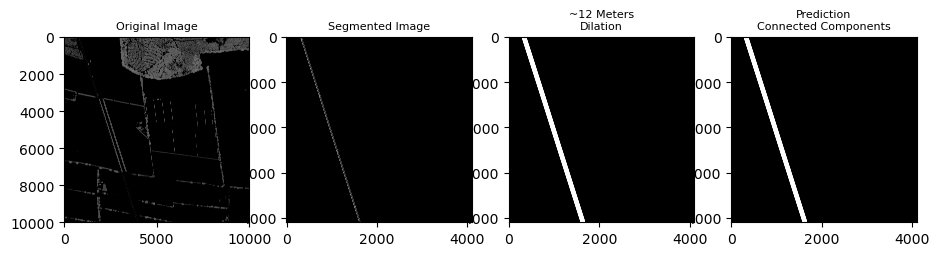

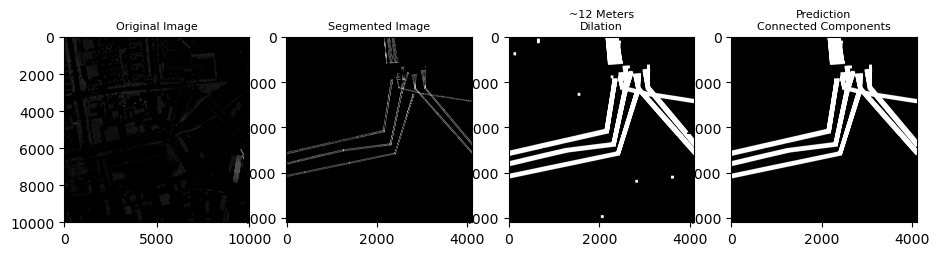

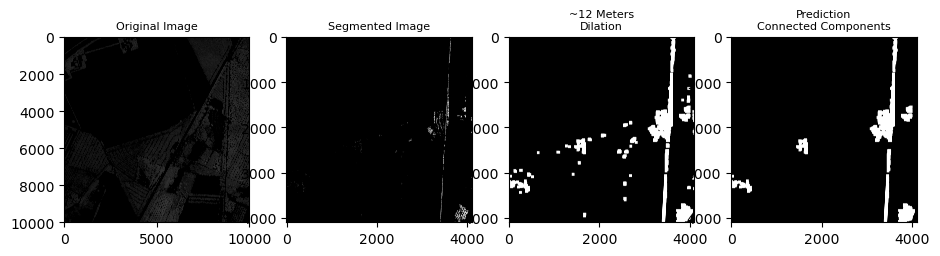

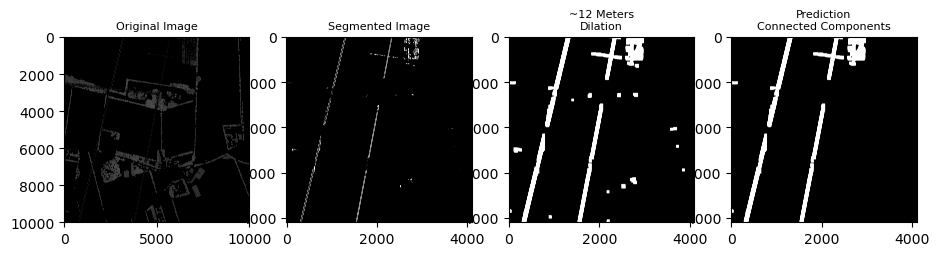

In [2]:
import open3d as o3d
path_to_data = "/home/frederik/data/TestData/data/"
#path_to_data = "/home/frederik/Downloads/cnn_test_data"
#path_to_model = "large4096patches128batch256/bestModelStateDict.pth"
path_to_model = "/home/frederik/Desktop/tmp/bestModelStateDict.pth"

network_size = 128
image_size = 4096
meters_around_line = 12
cc_area = 20000
simplify_tolerance = 8

clf = PolygonCNN(path_to_data, path_to_model, network_size, image_size, meters_around_line, cc_area, simplify_tolerance)

names = ["PUNKTSKY_00005_1km_6134_518",
        "PUNKTSKY_00005_1km_6146_468",
        "PUNKTSKY_00005_1km_6161_465",
        "PUNKTSKY_00005_1km_6162_472",
        "PUNKTSKY_00005_1km_6163_472",
        "PUNKTSKY_00005_1km_6167_473",
        "PUNKTSKY_00005_1km_6167_474",
        "PUNKTSKY_00005_1km_6167_475",
        "PUNKTSKY_00005_1km_6168_458",
        "PUNKTSKY_00005_1km_6204_505",
        "PUNKTSKY_00005_1km_6205_513",
        "PUNKTSKY_00005_1km_6211_474",
        "PUNKTSKY_00005_1km_6219_494",
        "PUNKTSKY_00005_1km_6220_495",
        "PUNKTSKY_00005_1km_6221_452"]


# names = ["PUNKTSKY_00004_1km_6105_518",
#          "PUNKTSKY_00004_1km_6106_492",
#          "PUNKTSKY_00004_1km_6106_493",
#          "PUNKTSKY_00004_1km_6106_494",
#          "PUNKTSKY_00004_1km_6106_510"]


reductions = []
pl_reduction = []
for name in names[:4]:
    las = laspy.read(path_to_data+'/LazFilesWithHeightParam/'+name+'_hag_nn.laz', laz_backend=laspy.compression.LazBackend.LazrsParallel)
    original_powerline_points = np.sum(las.classification == 14)

    new_point_cloud = clf(name)
    new_powerline_points = np.sum(new_point_cloud.classification == 14)
    point_data = np.stack([new_point_cloud.X, new_point_cloud.Y, new_point_cloud.Z], axis=0).transpose((1, 0))
    
    reductions.append(1 - len(new_point_cloud)/len(las))
    pl_reduction.append((original_powerline_points-new_powerline_points)/original_powerline_points)

    print(name + " & " + str(len(las)) + " & " + str(original_powerline_points)+ " & " + str(len(new_point_cloud)) + " & " + str((1 - len(new_point_cloud)/len(las))) + " & " + str(original_powerline_points-new_powerline_points))  
    
    
    #geom = o3d.geometry.PointCloud()
    #geom.points = o3d.utility.Vector3dVector(point_data)
    #o3d.visualization.draw_geometries([geom])

print("Avg Reduction Point Reduction: ", np.mean(reductions))

print("Avg PL Reduction: ", np.mean(reductions))
